# The Data Science of AWS Spot Pricing

Amazon Web Services is the 800-lb gorrilla in Cloud Computing and provides a number of different pricing models ranging from pay-per-use (called on-demand), fixed (called reserved pricing), and auction-based (called Spot). This latter model is on the order of 8–10x cheaper as compared with on-demand, but with a twist: since its auctioned, you may or may not “win” the auction. Even if you win and get the resources you are asking for, you may subsequently loose them with very little notice depending on the next auction and how others are bidding. Despite this added complexity, with almost an order of magnitude cost savings, its worth exploring how to use Spot in at least part of your workloads. 

AWS provides data on market prices for each instance type in each availability zone for the trailing 90 days. For example, Figure 1 shows the market price for a cc3.8xlarge in us-east-1a for the past week. On average, its 10x below the on-demand price of $2.40/hr, but there are spikes in the pricing. When the market price exceeds your bid price, then your resources will be lost with very little notice. So you have to set your bid price balancing volatility and cost — the spikes can easily exceed the on-demand cost of the same resource. 

Therefore, it’s worthwhile to build algorithms to manage your spot requests dynamically based on current market forces — similar to algorithmic trading algorithms that buy and sell stock for profit. And in this article I will show you how to do exactly that. Using some common open-source data science tools, I’ll show you how to access the spot market price data, manipulate and graph the data. I’ll leave it up to you to develop your own algorithms, but with the available tool set, its very accessible even to non-expert programmers.

All the code is accessible in this github repository. The toolset uses iPython, a web-based interactive programming environment similar to Mathematica or Matlab; Pandas for data manipulation; and Mathplotlib for graphing. You can add DSK for modeling, scikit for machine learning and even theano for deep learning. To run the code you will need an AWS account. Lets get started …


## Getting Started

Inputs to the notebook include the instance types you are interested in, as well as the number of days of data to pull in.  

* `instance_types` - an array of instance types, such as `m2.xlarge` or `t1.micro`.  see [aws instance types](http://aws.amazon.com/ec2/instance-types/)
* `region` - the region to query, eg. `us-east-1`
* `number_of_days` - number of days back t look.  must be between 1 and 90.

Alternatively you can specify the date strings specifically (the `date -v` sometimes generates some erronous dates).

In [82]:
instance_types  = ['c3.xlarge', 'c3.2xlarge', 'c3.4xlarge', 'c3.8xlarge']
region = 'us-east-1'
number_of_days = 10

end = !date -u "+%Y-%m-%dT%H:%M:%S"
end = end[0]
start = !date -v "-{number_of_days}d" -u "+%Y-%m-%dT%H:%M:%S"
start = start[0]
print "will process from " + start + " to " + end

will process from 2015-09-04T14:32:59 to 2015-09-14T14:32:59


Now we configure and use the Boto python libraries that connect to AWS apis and retrieve the spot price history.  The boto libraries require an AWS account with valid AWS_ACCESS_KEY_ID and AWS_SECRET_ACCESS_KEY.  I've added them to my bash configuration and the boto initialization picks it up there.  


In [83]:
import sys
import boto as boto
import boto.ec2 as ec2
import datetime, time
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.mpl_style', 'default') # Make the graphs a bit prettier
%pylab inline
%matplotlib inline

ec2 = boto.ec2.connect_to_region(region)


Populating the interactive namespace from numpy and matplotlib


Now we download the data using the api.  

In [84]:

#
# process the output and convert to a dataframe
#

l = []
for instance in instance_types:
    sys.stdout.write("*** processing " + instance + " ***\n")
    sys.stdout.flush()
    prices = ec2.get_spot_price_history(start_time=start, end_time=end, instance_type=instance)
    for price in prices:
        d = {'InstanceType': price.instance_type, 
             'AvailabilityZone': price.availability_zone, 
             'SpotPrice': price.price, 
             'Timestamp': price.timestamp}
        l.append(d)
    next = prices.next_token
    while (next != ''):
        sys.stdout.write(".")
        sys.stdout.flush()
        prices = ec2.get_spot_price_history(start_time=start, end_time=end, instance_type=instance,
                                            next_token=next )
        for price in prices:
            d = {'InstanceType': price.instance_type, 
                 'AvailabilityZone': price.availability_zone, 
                 'SpotPrice': price.price, 
                 'Timestamp': price.timestamp}
            l.append(d)
        next = prices.next_token
        
    sys.stdout.write("\n")

df = pd.DataFrame(l)
df = df.set_index(pd.to_datetime(df['Timestamp']))


*** processing c3.xlarge ***
..............................
*** processing c3.2xlarge ***
..........................................
*** processing c3.4xlarge ***
.......................................
*** processing c3.8xlarge ***
..............................................


This might look complicated, its not really. The script uses the ec2.get_spot_price_history api call to download the data for each instance type, and since the data may come in batches, it downloads each batch until it has all the data you are asking for. In the end, it converts the data into a dataframe so you can easily manipulate and graph it.

## Data Analysis 1

The data has a timestamp, instance type, availability zone, and the market price at that timestamp. The first thing we can do is plot the price over time to see the volatility of the c3.8xlarge market for each availability zone:

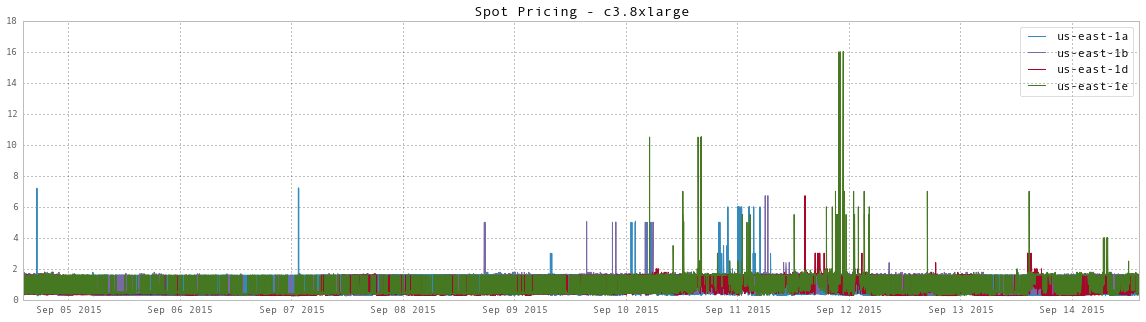

In [108]:
plt.figure(1, figsize(20,5))
for azName, azData in df[df.InstanceType=='c3.8xlarge'].groupby(['AvailabilityZone'], as_index=False):
    plt.plot(azData.index, azData['SpotPrice'],label=azName)
plt.legend()
plt.title('Spot Pricing - c3.8xlarge')
plt.show()

We can also easily generate a price histogram, this time looking at a single AZ and partitioning out the data for the 4 instance types in the family:

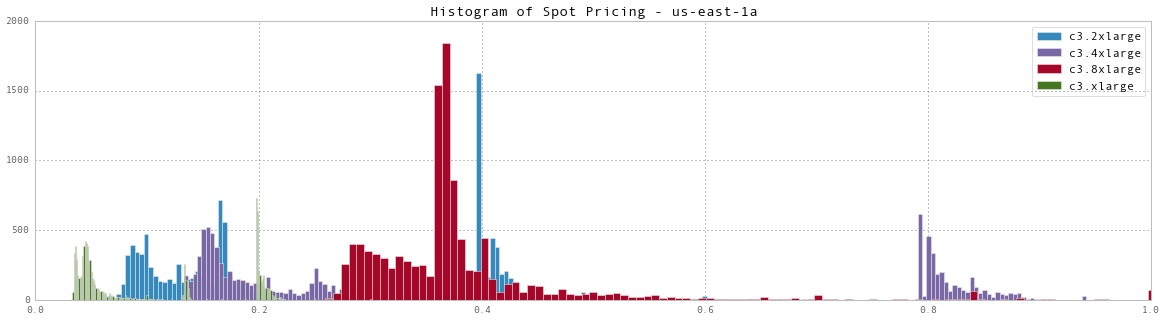

In [109]:
plt.figure(1, figsize(20,5))
for inName, inData in df[df.AvailabilityZone=='us-east-1a'].groupby(['InstanceType'], as_index=False):
    plt.hist(inData['SpotPrice'], bins=1000,label=inName)
    plt.xlim([0,1])
plt.legend()
plt.title('Histogram of Spot Pricing - us-east-1a')
plt.show()

This histogram shows you that (at least for us-east-1a AZ) in general as you go from smaller to larger instance types the hourly price also increases. To the c3.xlarge in green on the left is the least expensive, c3.2xlarge the next expensive, and so on. The c3.8xlarge, in contrast, is often half as expensive as a c3.4xlarge which is 1/2 as powerful. When making spot requests, it is beneficial to consider multiple instance types to get the lowest price.

It is also interesting to note that each instance type has a minimum price, and the c3.2xlarge minimum price is almost exactly 2 times the minimum price of the c3.xlarge, and the c3.4xlarge minimum prices is 2x the c3.2xlarge, and so on. You can also easily generate numerical averages and variances to produce exact values in addition to visual analysis via graphs.

In [86]:
df.groupby(['InstanceType'], as_index=False).agg([mean, std, min, max])

SpotPrice                         
                  mean       std     min    max
InstanceType                                   
c3.2xlarge    0.208698  0.168137  0.0641   4.20
c3.4xlarge    0.357193  0.295891  0.1305   4.80
c3.8xlarge    0.817229  0.610983  0.2577  16.02
c3.xlarge     0.087611  0.068220  0.0321   1.12

## Price Trends

Another hypothesis is that the market prices vary by time of day or day of the week. We can extract the hour or day of each recorded price data and determine the average/stdev for each hour of the day. Figure 5 shows both the average and standard deviation of the values by hour for the c3.xlarge instance.

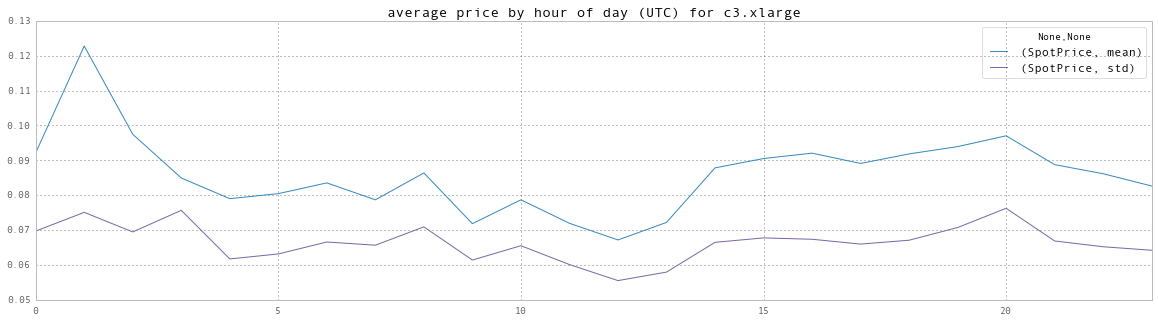

In [112]:
eight = df[df.InstanceType=='c3.xlarge']
eight.groupby(eight.index.hour).agg([mean, std]).plot(title='average price by hour of day (UTC) for c3.xlarge')

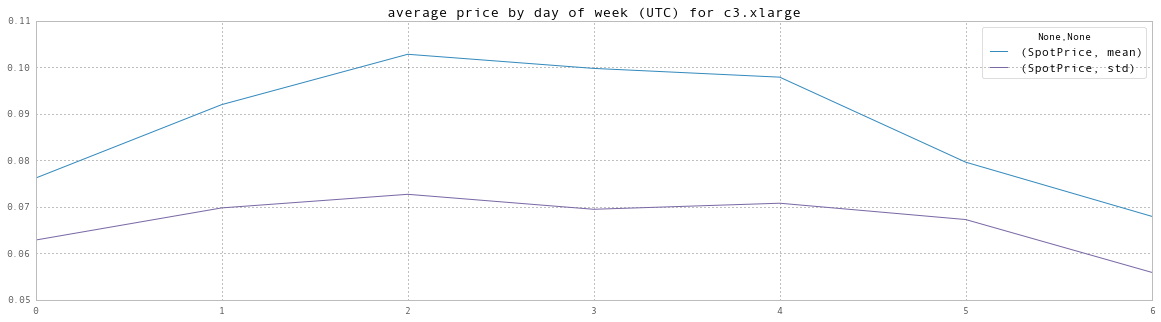

In [113]:
eight = df[df.InstanceType=='c3.xlarge']
eight.groupby(eight.index.dayofweek).agg([mean, std]).plot(title='average price by day of week (UTC) for c3.xlarge')


Second step is to simply plot the results.  Like the histograms, let's separate the instance types and show spot price (y axis) as a function of time (x-axis).  The different colors represent different availability zones.

# Conclusions

The examples shown here show that accessing and analyzing the historical spot pricing is easy using modern data science toolsets and very simple calculations and aggregations can lead to insight that can save you significant money.

But be warned: the pricing changes week to week and even day to day. If Netflix decides they need to re-encode all their movies for the new AppleTV, then the price and availability statistics of the instances will change dramatically. Your mileage will vary and that’s why it is important to build algorithms that can adapt to market fluxuations.

With this as your basis, you can go in a number of interesting directions, for example:

determine the lower bound on the probability that the market price will exceed your bid price, and hence, the probability that your resources will complete their computation,
analyze the volatility of each AZ and instance type in order to determine where to request instances,
use more advanced techniques to find recurring patterns in the data that you can then take advantage of.
If you have any thoughts or comments, feel free to post here or contact me at: karan.bhatia@gmail.com

